<a href="https://colab.research.google.com/github/JSJeong-me/GPT-Insights/blob/main/05-CSV_Data_OpenAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Interacting with a CSV Data

스마트서울 도시데이터 센서(S-DoT) 2분단위 환경정보
더보기
※  데이터 변환으로 2024년 7월 10일 이후 부터 이용 가능합니다.
### 서울시 전역(1100곳)에 설치된 S-DoT 복합 센서를 통해 2분 간격으로 수집되는 기온, 상대습도, 조도, 소음, 진동, 자외선, 풍향, 풍속, 흑구온도, 대기오염물질, 악취 등의 환경정보 데이터입니다.
### 서울 열린데이터광장에서는 동일 데이터로 1시간 단위 평균값으로 제공하고 있습니다.


In [ ]:
!pip install python-dotenv openai langchain langchain-core langchain-community langchain_experimental

In [2]:
from google.colab import userdata
import openai
import os

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
openai.api_key  = os.environ["OPENAI_API_KEY"]

In [3]:
import os
import pandas as pd

from IPython.display import Markdown, HTML, display
from langchain.schema import HumanMessage
from langchain.llms import OpenAI

llm = OpenAI(model="gpt-3.5-turbo-instruct", temperature=0.0)


<ipython-input-3-90bab3237c48>:8: LangChainDeprecationWarning: The class `OpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAI``.
  llm = OpenAI(model="gpt-3.5-turbo-instruct", temperature=0.0)


## Load the dataset

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zcBjhPUcSU72Iik22GzLPyGtQwTrq3Qa' -O wv-corelation.xlsx

In [5]:
import os
import pandas as pd

# Load the Excel file
file_path = 'wv-corelation.xlsx'

# Read the Excel file into a DataFrame
df = pd.read_excel(file_path)

# Display the first few rows of the DataFrame to understand its structure
df.head()

,ds,wv,dp-pre,dp-med,co2,current,temperature,humidity
0,2023-09-25 10:12:00,8516.666667,164.666667,164.666667,502.750000,4.930000,164.666667,48.760
1,2023-09-25 10:13:00,8526.333333,153.666667,153.666667,507.000000,4.926667,153.666667,48.790
2,2023-09-25 10:14:00,8525.500000,176.666667,176.666667,505.666667,4.853333,176.666667,48.850
3,2023-09-25 10:15:00,8516.666667,159.000000,159.000000,495.750000,4.780000,159.000000,48.805
4,2023-09-25 10:16:00,8556.000000,160.666667,160.666667,499.250000,4.910000,160.666667,48.805


In [6]:
# Convert the 'ds' column to datetime format
df['ds'] = pd.to_datetime(df['ds'])

# Set the 'ds' column as the index
df.set_index('ds', inplace=True)

# Resample the data to 1-hour intervals and calculate the mean for each interval
df_resampled = df.resample('1H').mean()

# Display the first few rows of the resampled DataFrame
print(df_resampled.head())
df = df_resampled

                              wv      dp-pre      dp-med         co2  \
ds                                                                     
2023-09-25 10:00:00  8538.402778  168.920139  168.920139  498.748264   
2023-09-25 11:00:00  8533.154167  169.433333  169.433333  494.368750   
2023-09-25 12:00:00  8525.065278  167.944444  167.944444  490.602778   
2023-09-25 13:00:00  8524.113889  166.961111  166.961111  495.683333   
2023-09-25 14:00:00  8508.705556  167.133333  167.133333  506.613889   

                      current  temperature   humidity  
ds                                                     
2023-09-25 10:00:00  5.058723   168.920139  48.680330  
2023-09-25 11:00:00  5.058757   169.433333  48.603458  
2023-09-25 12:00:00  4.922249   167.944444  48.751278  
2023-09-25 13:00:00  4.792353   166.961111  49.195910  
2023-09-25 14:00:00  4.786330   167.133333  49.566660  


<ipython-input-6-91d978df7ee9>:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample('1H').mean()


## Prepare the Langchain dataframe agent

In [7]:
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent

# Ensure you have your LLM instance created as `llm`

agent = create_pandas_dataframe_agent(llm=llm, df=df, verbose=True, allow_dangerous_code=True)

# Now you can invoke the agent with a query
response = agent.invoke("what are the names of the columns?")
print(response)



> Entering new AgentExecutor chain...
Thought: I need to access the dataframe's columns attribute
Action: python_repl_ast
Action Input: df.columnsIndex(['wv', 'dp-pre', 'dp-med', 'co2', 'current', 'temperature', 'humidity'], dtype='object') I now know the final answer
Final Answer: The names of the columns are 'wv', 'dp-pre', 'dp-med', 'co2', 'current', 'temperature', and 'humidity'.

> Finished chain.
{'input': 'what are the names of the columns?', 'output': "The names of the columns are 'wv', 'dp-pre', 'dp-med', 'co2', 'current', 'temperature', and 'humidity'."}


## Design your prompt and ask your question



> Entering new AgentExecutor chain...
Thought: I need to set the pandas display options to show all columns
Action: python_repl_ast
Action Input: pd.set_option('display.max_columns', None) I need to get the column names
Action: python_repl_ast
Action Input: df.columnsIndex(['wv', 'dp-pre', 'dp-med', 'co2', 'current', 'temperature', 'humidity'], dtype='object') I need to calculate the correlation of the 'wv' column with the remaining input columns
Action: python_repl_ast
Action Input: df.corr()['wv']wv             1.000000
dp-pre         0.073339
dp-med         0.073339
co2           -0.066431
current       -0.142634
temperature    0.073339
humidity       0.247938
Name: wv, dtype: float64 I need to draw a heatmap to visualize the correlation
Action: python_repl_ast
Action Input: sns.heatmap(df.corr())NameError: name 'sns' is not defined I need to import the seaborn library to use the heatmap function
Action: python_repl_ast
Action Input: import seaborn as sns I need to draw a heatmap 

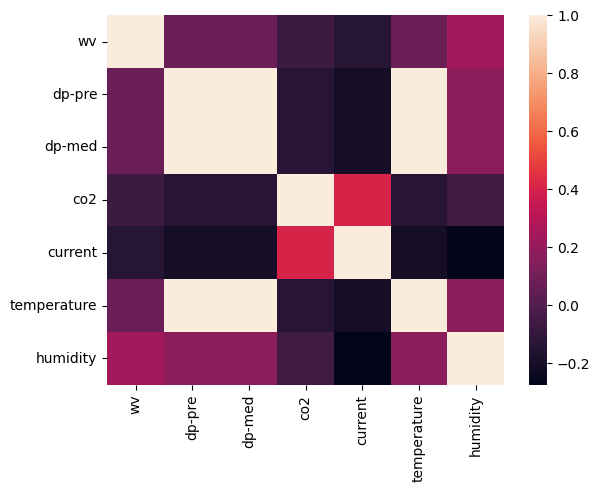

In [9]:
CSV_PROMPT_PREFIX = """
First set the pandas display options to show all the columns,
get the column names, then answer the question.
"""

CSV_PROMPT_SUFFIX = """
Your task is to answer the question using the provided dataframe.

**Guidelines:**

1. **Thorough Analysis:** Before providing your final answer, analyze the data using at least two different methods if possible.  This will help ensure the accuracy and reliability of your results.
2. **Reflection:** Carefully consider the results obtained from each method. Do they align with your understanding of the question and the data? If not, try another method or adjust your approach until you achieve consistency.
3. **Final Answer:** When you are confident in your answer, present it in a clear and concise manner using Markdown.
4. **Explanation:** Always include a detailed explanation of how you arrived at your final answer. This should involve mentioning the specific column names used, the methods employed, and any relevant insights or observations.
5. **Avoid Assumptions:** Do not make up answers or use prior knowledge. Base your response solely on the information provided in the dataframe and the results of your calculations.
6. **Uncertainty:** If, after multiple attempts, you are still unable to arrive at a consistent and reliable answer, acknowledge this uncertainty in your response. Explain the challenges you encountered and the reasons why you are unsure.


**Final Answer:**
<Your final answer here>

**Explanation:**
<Your explanation here>
"""

QUESTION = "Calculate and analyze the correlation of the 'wv' column with the remaining input columns of the 'target variable' and draw a heatmap."


response = agent.invoke(CSV_PROMPT_PREFIX + QUESTION + CSV_PROMPT_SUFFIX, handle_parsing_errors=True)
print(response)

In [10]:
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent

# Ensure you have your LLM instance created as `llm`

agent = create_pandas_dataframe_agent(llm=llm, df=df, verbose=True, allow_dangerous_code=True)

# Now you can invoke the agent with a query
response = agent



> Entering new AgentExecutor chain...
Thought: I need to set the pandas display options to show all columns
Action: python_repl_ast
Action Input: pd.set_option('display.max_columns', None)NameError: name 'pd' is not defined I need to import pandas as pd
Action: python_repl_ast
Action Input: import pandas as pd I need to set the pandas display options to show all columns
Action: python_repl_ast
Action Input: pd.set_option('display.max_columns', None) I need to get the column names
Action: python_repl_ast
Action Input: df.columnsIndex(['wv', 'dp-pre', 'dp-med', 'co2', 'current', 'temperature', 'humidity'], dtype='object') I need to calculate the correlation of the 'wv' column with the remaining input columns of the 'target variable'
Action: python_repl_ast
Action Input: df.corr()['wv']wv             1.000000
dp-pre         0.073339
dp-med         0.073339
co2           -0.066431
current       -0.142634
temperature    0.073339
humidity       0.247938
Name: wv, dtype: float64 I need to d

{'input': "\nFirst set the pandas display options to show all the columns,\nget the column names, then answer the question.\nCalculate and analyze the correlation of the 'wv' column with the remaining input columns of the 'target variable' and draw a heatmap.\nYour task is to answer the question using the provided dataframe.\n\n**Guidelines:**\n\n1. **Thorough Analysis:** Before providing your final answer, analyze the data using at least two different methods if possible.  This will help ensure the accuracy and reliability of your results.\n2. **Reflection:** Carefully consider the results obtained from each method. Do they align with your understanding of the question and the data? If not, try another method or adjust your approach until you achieve consistency.\n3. **Final Answer:** When you are confident in your answer, present it in a clear and concise manner using Markdown.  \n4. **Explanation:** Always include a detailed explanation of how you arrived at your final answer. This 

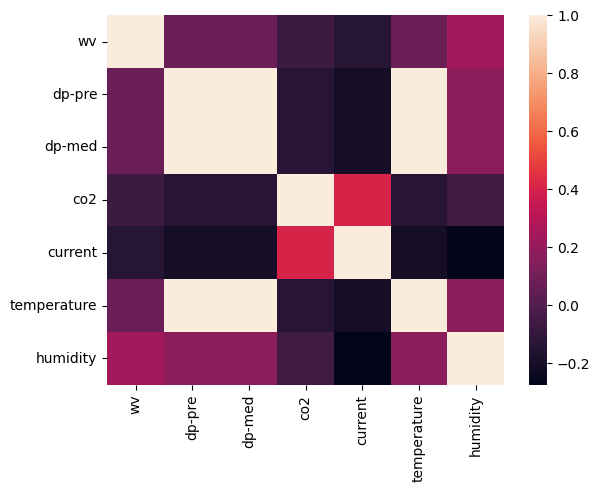

In [11]:
QUESTION = "Calculate and analyze the correlation of the 'wv' column with the remaining input columns of the 'target variable' and draw a heatmap."


agent.invoke(CSV_PROMPT_PREFIX + QUESTION + CSV_PROMPT_SUFFIX)